In [49]:
# Import standard libraries for randomness, deep copying, and numerical operations
import random
import numpy as np
from copy import deepcopy
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Import libraries for image processing and data manipulation
from PIL import Image
import pandas as pd
from collections import defaultdict

# Import PyTorch core and utilities for deep learning
import torch
import torch.optim as optim  # Optimization algorithms
import torch.nn as nn  # Neural network modules
import torch.nn.functional as F  # Functional API for non-parametric operations

# Import PyTorch utilities for data loading and transformations
from torch.utils.data import DataLoader, Dataset, random_split, WeightedRandomSampler
from torchvision.transforms.v2 import Compose, ToImage, Normalize, ToPILImage, Resize, ToDtype
from torchvision import transforms

# Import dataset handling and learning rate schedulers
from torchvision.datasets import ImageFolder
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, MultiStepLR, CyclicLR, LambdaLR

# Import visualization and web utilities
from tqdm import trange
import matplotlib.pyplot as plt
import requests
import zipfile
import os
import errno

# Set matplotlib style for better visuals
#plt.style.use('fivethirtyeight')

## Architecture class

In [50]:
class Architecture(object):
    def __init__(self, model, loss_fn, optimizer):
        # Here we define the attributes of our class

        # We start by storing the arguments as attributes
        # to use them later
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        print(f"Using device: {self.device}")
        
        # Let's send the model to the specified device right away
        self.model.to(self.device)

        # These attributes are defined here, but since they are
        # not informed at the moment of creation, we keep them None
        self.train_loader = None
        self.val_loader = None

        # These attributes are going to be computed internally
        self.losses = []
        self.val_losses = []
        self.total_epochs = 0

        # Creates the train_step function for our model,
        # loss function and optimizer
        # Note: there are NO ARGS there! It makes use of the class
        # attributes directly
        self.train_step_fn = self._make_train_step_fn()
        # Creates the val_step function for our model and loss
        self.val_step_fn = self._make_val_step_fn()

        # for hook purposes
        self.handles = {}
        self.visualization = {}

    def to(self, device):
        # This method allows the user to specify a different device
        # It sets the corresponding attribute (to be used later in
        # the mini-batches) and sends the model to the device
        try:
            self.device = device
            self.model.to(self.device)
        except RuntimeError:
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
            print(f"Couldn't send it to {device}, sending it to {self.device} instead.")
            self.model.to(self.device)

    def set_loaders(self, train_loader, val_loader=None):
        # This method allows the user to define which train_loader (and val_loader, optionally) to use
        # Both loaders are then assigned to attributes of the class
        # So they can be referred to later
        self.train_loader = train_loader
        self.val_loader = val_loader

    def _make_train_step_fn(self):
        # This method does not need ARGS... it can refer to
        # the attributes: self.model, self.loss_fn and self.optimizer

        # Builds function that performs a step in the train loop
        def perform_train_step_fn(x, y):
            # Sets model to TRAIN mode
            self.model.train()

            # Step 1 - Computes our model's predicted output - forward pass
            yhat = self.model(x)
            # Step 2 - Computes the loss
            loss = self.loss_fn(yhat, y)
            # Step 3 - Computes gradients for both "a" and "b" parameters
            loss.backward()
            # Step 4 - Updates parameters using gradients and the learning rate
            self.optimizer.step()
            self.optimizer.zero_grad()

            # Returns the loss
            return loss.item()

        # Returns the function that will be called inside the train loop
        return perform_train_step_fn

    def _make_val_step_fn(self):
        # Builds function that performs a step in the validation loop
        def perform_val_step_fn(x, y):
            # Sets model to EVAL mode
            self.model.eval()

            # Step 1 - Computes our model's predicted output - forward pass
            yhat = self.model(x)
            # Step 2 - Computes the loss
            loss = self.loss_fn(yhat, y)
            # There is no need to compute Steps 3 and 4, since we don't update parameters during evaluation
            return loss.item()

        return perform_val_step_fn

    def _mini_batch(self, validation=False):
        # The mini-batch can be used with both loaders
        # The argument `validation`defines which loader and
        # corresponding step function is going to be used
        if validation:
            data_loader = self.val_loader
            step_fn = self.val_step_fn
        else:
            data_loader = self.train_loader
            step_fn = self.train_step_fn

        if data_loader is None:
            return None

        # Once the data loader and step function, this is the same
        # mini-batch loop we had before
        mini_batch_losses = []
        for x_batch, y_batch in data_loader:
            x_batch = x_batch.to(self.device)
            y_batch = y_batch.to(self.device)

            mini_batch_loss = step_fn(x_batch, y_batch)
            mini_batch_losses.append(mini_batch_loss)

        loss = np.mean(mini_batch_losses)
        return loss

    # this function was updated in this class
    def set_seed(self, seed=42):
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        torch.manual_seed(seed)
        np.random.seed(seed)
        random.seed(seed)
        try:
            self.train_loader.sampler.generator.manual_seed(seed)
        except AttributeError:
            pass

    def train(self, n_epochs, seed=42):
        # To ensure reproducibility of the training process
        self.set_seed(seed)

        for epoch in trange(n_epochs, desc="Training Progress"):
            # Keeps track of the numbers of epochs
            self.total_epochs += 1

            # inner loop
            # Performs training using mini-batches
            loss = self._mini_batch(validation=False)
            self.losses.append(loss)

            # VALIDATION
            # no gradients in validation!
            with torch.no_grad():
                # Performs evaluation using mini-batches
                val_loss = self._mini_batch(validation=True)
                self.val_losses.append(val_loss)
            print(f"Epoch {epoch+1}/{n_epochs} - Loss: {loss:.4f} - Val Loss: {val_loss:.4f}")

    # def train(self, n_epochs, seed=42):
    #     # To ensure reproducibility of the training process
    #     self.set_seed(seed)

    #     for epoch in range(n_epochs):
    #         # Keeps track of the numbers of epochs
    #         # by updating the corresponding attribute
    #         self.total_epochs += 1

    #         # inner loop
    #         # Performs training using mini-batches
    #         loss = self._mini_batch(validation=False)
    #         self.losses.append(loss)

    #         # VALIDATION
    #         # no gradients in validation!
    #         with torch.no_grad():
    #             # Performs evaluation using mini-batches
    #             val_loss = self._mini_batch(validation=True)
    #             self.val_losses.append(val_loss)

    def save_checkpoint(self, filename):
        # Builds dictionary with all elements for resuming training
        checkpoint = {'epoch': self.total_epochs,
                      'model_state_dict': self.model.state_dict(),
                      'optimizer_state_dict': self.optimizer.state_dict(),
                      'loss': self.losses,
                      'val_loss': self.val_losses}

        torch.save(checkpoint, filename)

    def load_checkpoint(self, filename):
        # Loads dictionary
        checkpoint = torch.load(filename)

        # Restore state for model and optimizer
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

        self.total_epochs = checkpoint['epoch']
        self.losses = checkpoint['loss']
        self.val_losses = checkpoint['val_loss']

        self.model.train() # always use TRAIN for resuming training

    def predict(self, x):
        # Set is to evaluation mode for predictions
        self.model.eval()
        # Takes aNumpy input and make it a float tensor
        x_tensor = torch.as_tensor(x).float()
        # Send input to device and uses model for prediction
        y_hat_tensor = self.model(x_tensor.to(self.device))
        # Set it back to train mode
        self.model.train()
        # Detaches it, brings it to CPU and back to Numpy
        return y_hat_tensor.detach().cpu().numpy()

    def count_parameters(self):
      return sum(p.numel() for p in self.model.parameters() if p.requires_grad)

    def plot_losses(self):
        fig = plt.figure(figsize=(10, 4))
        plt.plot(self.losses, label='Training Loss', c='b')
        plt.plot(self.val_losses, label='Validation Loss', c='r')
        plt.yscale('log')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.tight_layout()
        return fig

    @staticmethod
    def _visualize_tensors(axs, x, y=None, yhat=None, layer_name='', title=None):
        # The number of images is the number of subplots in a row
        n_images = len(axs)
        # Gets max and min values for scaling the grayscale
        minv, maxv = np.min(x[:n_images]), np.max(x[:n_images])
        # For each image
        for j, image in enumerate(x[:n_images]):
            ax = axs[j]
            # Sets title, labels, and removes ticks
            if title is not None:
                ax.set_title(f'{title} #{j}', fontsize=12)
            shp = np.atleast_2d(image).shape
            ax.set_ylabel(
                f'{layer_name}\n{shp[0]}x{shp[1]}',
                rotation=0, labelpad=40
            )
            xlabel1 = '' if y is None else f'\nLabel: {y[j]}'
            xlabel2 = '' if yhat is None else f'\nPredicted: {yhat[j]}'
            xlabel = f'{xlabel1}{xlabel2}'
            if len(xlabel):
                ax.set_xlabel(xlabel, fontsize=12)
            ax.set_xticks([])
            ax.set_yticks([])

            # Plots weight as an image
            ax.imshow(
                np.atleast_2d(image.squeeze()),
                cmap='gray',
                vmin=minv,
                vmax=maxv
            )
        return

    def visualize_filters(self, layer_name, **kwargs):
        try:
            # Gets the layer object from the model
            layer = self.model
            for name in layer_name.split('.'):
                layer = getattr(layer, name)
            # We are only looking at filters for 2D convolutions
            if isinstance(layer, nn.Conv2d):
                # Takes the weight information
                weights = layer.weight.data.cpu().numpy()
                # weights -> (channels_out (filter), channels_in, H, W)
                n_filters, n_channels, _, _ = weights.shape

                # Builds a figure
                size = (2 * n_channels + 2, 2 * n_filters)
                fig, axes = plt.subplots(n_filters, n_channels,
                                        figsize=size)
                axes = np.atleast_2d(axes)
                axes = axes.reshape(n_filters, n_channels)
                # For each channel_out (filter)
                for i in range(n_filters):
                    Architecture._visualize_tensors(
                        axes[i, :],
                        weights[i],
                        layer_name=f'Filter #{i}',
                        title='Channel'
                    )

                for ax in axes.flat:
                    ax.label_outer()

                fig.tight_layout()
                return fig
        except AttributeError:
            return

    def attach_hooks(self, layers_to_hook, hook_fn=None):
        # Clear any previous values
        self.visualization = {}
        # Creates the dictionary to map layer objects to their names
        modules = list(self.model.named_modules())
        layer_names = {layer: name for name, layer in modules[1:]}

        if hook_fn is None:
            # Hook function to be attached to the forward pass
            def hook_fn(layer, inputs, outputs):
                # Gets the layer name
                name = layer_names[layer]
                # Detaches outputs
                values = outputs.detach().cpu().numpy()
                # Since the hook function may be called multiple times
                # for example, if we make predictions for multiple mini-batches
                # it concatenates the results
                if self.visualization[name] is None:
                    self.visualization[name] = values
                else:
                    self.visualization[name] = np.concatenate([self.visualization[name], values])

        for name, layer in modules:
            # If the layer is in our list
            if name in layers_to_hook:
                # Initializes the corresponding key in the dictionary
                self.visualization[name] = None
                # Register the forward hook and keep the handle in another dict
                self.handles[name] = layer.register_forward_hook(hook_fn)

    def remove_hooks(self):
        # Loops through all hooks and removes them
        for handle in self.handles.values():
            handle.remove()
        # Clear the dict, as all hooks have been removed
        self.handles = {}

    def visualize_outputs(self, layers, n_images=10, y=None, yhat=None):
        layers = filter(lambda l: l in self.visualization.keys(), layers)
        layers = list(layers)
        shapes = [self.visualization[layer].shape for layer in layers]
        n_rows = [shape[1] if len(shape) == 4 else 1
                  for shape in shapes]
        total_rows = np.sum(n_rows)

        fig, axes = plt.subplots(total_rows, n_images,
                                figsize=(1.5*n_images, 1.5*total_rows))
        axes = np.atleast_2d(axes).reshape(total_rows, n_images)

        # Loops through the layers, one layer per row of subplots
        row = 0
        for i, layer in enumerate(layers):
            start_row = row
            # Takes the produced feature maps for that layer
            output = self.visualization[layer]

            is_vector = len(output.shape) == 2

            for j in range(n_rows[i]):
                Architecture._visualize_tensors(
                    axes[row, :],
                    output if is_vector else output[:, j].squeeze(),
                    y,
                    yhat,
                    layer_name=layers[i] \
                              if is_vector \
                              else f'{layers[i]}\nfil#{row-start_row}',
                    title='Image' if (row == 0) else None
                )
                row += 1

        for ax in axes.flat:
            ax.label_outer()

        plt.tight_layout()
        return fig

    def correct(self, x, y, threshold=.5):
        self.model.eval()
        yhat = self.model(x.to(self.device))
        y = y.to(self.device)
        self.model.train()

        # We get the size of the batch and the number of classes
        # (only 1, if it is binary)
        n_samples, n_dims = yhat.shape
        if n_dims > 1:
            # In a multiclass classification, the biggest logit
            # always wins, so we don't bother getting probabilities

            # This is PyTorch's version of argmax,
            # but it returns a tuple: (max value, index of max value)
            _, predicted = torch.max(yhat, 1)
        else:
            n_dims += 1
            # In binary classification, we NEED to check if the
            # last layer is a sigmoid (and then it produces probs)
            if isinstance(self.model, nn.Sequential) and \
              isinstance(self.model[-1], nn.Sigmoid):
                predicted = (yhat > threshold).long()
            # or something else (logits), which we need to convert
            # using a sigmoid
            else:
                predicted = (F.sigmoid(yhat) > threshold).long()

        # How many samples got classified correctly for each class
        result = []
        for c in range(n_dims):
            n_class = (y == c).sum().item()
            n_correct = (predicted[y == c] == c).sum().item()
            result.append((n_correct, n_class))
        return torch.tensor(result)


    @staticmethod
    def loader_apply(loader, func, reduce='sum'):
        results = [func(x, y) for i, (x, y) in enumerate(loader)]
        results = torch.stack(results, axis=0)

        if reduce == 'sum':
            results = results.sum(axis=0)
        elif reduce == 'mean':
            results = results.float().mean(axis=0)

        return results

    @staticmethod
    def statistics_per_channel(images, labels):
        # NCHW
        n_samples, n_channels, n_height, n_weight = images.size()
        # Flatten HW into a single dimension
        flatten_per_channel = images.reshape(n_samples, n_channels, -1)

        # Computes statistics of each image per channel
        # Average pixel value per channel
        # (n_samples, n_channels)
        means = flatten_per_channel.mean(axis=2)
        # Standard deviation of pixel values per channel
        # (n_samples, n_channels)
        stds = flatten_per_channel.std(axis=2)

        # Adds up statistics of all images in a mini-batch
        # (1, n_channels)
        sum_means = means.sum(axis=0)
        sum_stds = stds.sum(axis=0)
        # Makes a tensor of shape (1, n_channels)
        # with the number of samples in the mini-batch
        n_samples = torch.tensor([n_samples]*n_channels).float()

        # Stack the three tensors on top of one another
        # (3, n_channels)
        return torch.stack([n_samples, sum_means, sum_stds], axis=0)

    @staticmethod
    def make_normalizer(loader):
        total_samples, total_means, total_stds = Architecture.loader_apply(loader, Architecture.statistics_per_channel)
        norm_mean = total_means / total_samples
        norm_std = total_stds / total_samples
        return Normalize(mean=norm_mean, std=norm_std)

    def lr_range_test(self, data_loader, end_lr, num_iter=100, step_mode='exp', alpha=0.05, ax=None):
        # Since the test updates both model and optimizer we need to store
        # their initial states to restore them in the end
        previous_states = {'model': deepcopy(self.model.state_dict()),
                          'optimizer': deepcopy(self.optimizer.state_dict())}
        # Retrieves the learning rate set in the optimizer
        start_lr = self.optimizer.state_dict()['param_groups'][0]['lr']

        # Builds a custom function and corresponding scheduler
        lr_fn = make_lr_fn(start_lr, end_lr, num_iter)
        scheduler = LambdaLR(self.optimizer, lr_lambda=lr_fn)    

        # Variables for tracking results and iterations
        tracking = {'loss': [], 'lr': []}
        iteration = 0

        # If there are more iterations than mini-batches in the data loader,
        # it will have to loop over it more than once
        while (iteration < num_iter):
            # That's the typical mini-batch inner loop
            for x_batch, y_batch in data_loader:
                x_batch = x_batch.to(self.device)
                y_batch = y_batch.to(self.device)
                # Step 1
                yhat = self.model(x_batch)
                # Step 2
                loss = self.loss_fn(yhat, y_batch)
                # Step 3
                loss.backward()

                # Here we keep track of the losses (smoothed)
                # and the learning rates
                tracking['lr'].append(scheduler.get_last_lr()[0])
                if iteration == 0:
                    tracking['loss'].append(loss.item())
                else:
                    prev_loss = tracking['loss'][-1]
                    smoothed_loss = alpha * loss.item() + (1-alpha) * prev_loss
                    tracking['loss'].append(smoothed_loss)

                iteration += 1
                # Number of iterations reached
                if iteration == num_iter:
                    break

                # Step 4
                self.optimizer.step()
                scheduler.step()
                self.optimizer.zero_grad()

        # Restores the original states
        self.optimizer.load_state_dict(previous_states['optimizer'])
        self.model.load_state_dict(previous_states['model'])

        if ax is None:
            fig, ax = plt.subplots(1, 1, figsize=(6, 4))
        else:
            fig = ax.get_figure()
        ax.plot(tracking['lr'], tracking['loss'])
        if step_mode == 'exp':
            ax.set_xscale('log')
        ax.set_xlabel('Learning Rate')
        ax.set_ylabel('Loss')
        fig.tight_layout()
        return tracking, fig

    def set_optimizer(self, optimizer):
        self.optimizer = optimizer



# Data Generation

>This dataset was created by combining two datasets from Kaggle: [Thitinan Kliangsuwan. Cloud Type Classification 3, 2022.](https://kaggle.com/competitions/cloud-type-classification-3) and [Howard-Cloud-X](https://www.kaggle.com/datasets/imbikramsaha/howard-cloudx). 



>The Howard-Cloud-X is licensed as [CC0: Public Domain](https://creativecommons.org/publicdomain/zero/1.0/).

In [51]:
# Path to the dataset
folder='../dataset/clouds_types'

In [52]:
def figure1(folder):
    #cirroculumulus = Image.open(f'{folder}/Cirroculumulus/cirroculumulus-002.jpg')
    #cirrostratus = Image.open(f'{folder}/Cirrostratus/cirrostratus-024.jpg')
    cirrus = Image.open(f'{folder}/Cirrus/cirrus-004.jpg')
    altocumulus = Image.open(f'{folder}/Altocumulus/altocumulus-000.jpg')
    #altostratus = Image.open(f'{folder}/Altostratus/altostratus-017.jpg')
    cumulonimbus = Image.open(f'{folder}/Cumulonimbus/cumulonimbus-030.jpg')
    cumulus = Image.open(f'{folder}/Cumulus/cumulus-000.jpg')
    nimbostratus = Image.open(f'{folder}/Nimbostratus/nimbostratus-000.jpg')
    clear_sky = Image.open(f'{folder}/Clear_Sky/clear_sky-008.jpg')
    #stratus = Image.open(f'{folder}/Stratus/stratus-000.jpg')


    images = [cirrus, altocumulus,cumulonimbus, cumulus, nimbostratus,clear_sky]
    titles = ['Cirrus','Altocumulus','Cumulonimbus', 'Cumulus', 'Nimbostratus',"Clear Sky"]

    fig, axs = plt.subplots(2, 3, figsize=(12, 5))
    for ax, image, title in zip(axs.flat, images, titles):
        ax.imshow(image)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(title)

    return fig



In [ ]:
fig = figure1(folder)

# Data Preparation

## ImageFolder

In [68]:
# Compose a sequence of preprocessing transforms
# 1) Resize images to 64×64 pixels
# 2) Ensure output is a PIL/torchvision Image (dropping any alpha channel)
# 3) Convert pixel values to float32 and scale from [0–255] to [0.0–1.0]

temp_transform = transforms.Compose([
    transforms.Resize((128,128)),        # Resize each image to 64×64
    ToImage(),                         # Convert tensor back to PIL Image (enforces RGB)
    ToDtype(torch.float32, scale=True) # Cast to float32 and normalize pixel range
])

# Create an ImageFolder dataset from the 'Cloud types' directory
# Images are grouped by subfolder name as class labels, and each image is transformed
temp_dataset = ImageFolder(
    root='../dataset/clouds_types',  # Path to the dataset
    transform=temp_transform      # Apply the preprocessing pipeline to every image
)

In [69]:
# Looking the shape of every images
temp_dataset[len(temp_dataset)-1][0].shape

torch.Size([3, 128, 128])

In [70]:
# Get total number of samples in the dataset
dataset_size = len(temp_dataset)
print(f"Dataset size: {dataset_size} images")

# Get number of classes
num_classes = len(temp_dataset.classes)
print(f"Number of classes: {num_classes}")

Dataset size: 657 images
Number of classes: 6


## Standardization

In [71]:
temp_loader = DataLoader(temp_dataset, batch_size=16)

In [72]:
# Each column represents a channel
# first row is the number of data points
# second row is the the sum of mean values
# third row is the sum of standard deviations
first_images, first_labels = next(iter(temp_loader))
Architecture.statistics_per_channel(first_images, first_labels)

tensor([[16.0000, 16.0000, 16.0000],
        [ 6.5846,  7.1044,  7.9007],
        [ 3.1242,  2.6483,  2.4392]])

In [73]:
# We can leverage the loader_apply() method to get the sums for the whole dataset:
results = Architecture.loader_apply(temp_loader, Architecture.statistics_per_channel)
results

tensor([[657.0000, 657.0000, 657.0000],
        [286.9025, 329.4191, 386.5164],
        [120.7550, 104.9532,  93.1536]])

In [74]:
# we can compute the average mean value and the average standard deviation, per channel.
# Better yet, let’s make it a method that takes a data loader and
# returns an instance of the Normalize() transform
normalizer = Architecture.make_normalizer(temp_loader)
normalizer

Normalize(mean=[tensor(0.4367), tensor(0.5014), tensor(0.5883)], std=[tensor(0.1838), tensor(0.1597), tensor(0.1418)], inplace=False)

## Real Dataset

In [75]:
# Define a pipeline of image transformations:
# 1) Resize each image to 128×128 pixels
# 2) Ensure the output is a PIL/torchvision image (dropping any alpha channel)
# 3) Cast pixels to float32 and scale from [0–255] to [0.0–1.0]
# 4) Apply the user-defined normalization (e.g., mean/std normalization)
composer = transforms.Compose([
    transforms.Resize((128,128)),       # Resize to 128×128
    ToImage(),                          # Convert to PIL Image in RGB
    ToDtype(torch.float32, scale=True), # Cast to float32 and normalize to [0,1]
    normalizer                          # Apply custom normalization transform
])

# Instantiate training and validation datasets from folders:
# - 'clouds_types' contains subfolders per class for training
# - 'clouds_types_test' likewise for validation
train_data = ImageFolder(root='../dataset/clouds_types', transform=composer)
val_data   = ImageFolder(root='../dataset/clouds_types_test', transform=composer)

# Wrap datasets in DataLoaders for batching and shuffling:
# - batch_size=16 yields mini-batches of 16 images
# - shuffle=True randomizes training order each epoch
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_data,   batch_size=16)  # no shuffle for validation

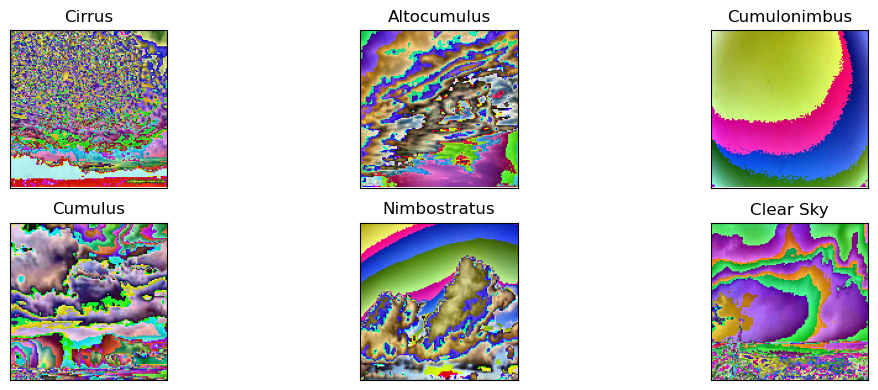

In [76]:
# Function to get one sample per class from the dataset

def get_one_per_class(dataset, num_classes):
    samples = defaultdict(list)
    for img, label in dataset:
        if label not in samples:
            samples[label] = img
        if len(samples) == num_classes:
            break
    images = [samples[i] for i in range(num_classes)]
    labels = list(range(num_classes))
    return images, labels

# Creating the plot

def figure2(first_images, first_labels):
    fig, axs = plt.subplots(2, 3, figsize=(12, 4))
    titles = ['Cirrus','Altocumulus','Cumulonimbus', 'Cumulus', 'Nimbostratus',"Clear Sky"]
    
    axs = axs.flatten()  # Flatten the 2D array of axes into a 1D array for easier indexing
    
    for i in range(6):
        # Ensure first_images[i] is a PyTorch tensor before using ToPILImage
        image_tensor = torch.tensor(first_images[i]) if isinstance(first_images[i], np.ndarray) else first_images[i]
        image, label = ToPILImage()(image_tensor), first_labels[i]
        
        axs[i].imshow(image)
        axs[i].set_xticks([])
        axs[i].set_yticks([])
        axs[i].set_title(titles[label], fontsize=12)
    
    # Hide any unused subplots
    # for j in range(6, len(axs)):
    #     axs[j].axis('off')
    
    fig.tight_layout()
    return fig

torch.manual_seed(88)
first_images, first_labels = get_one_per_class(train_loader.dataset, 6)
fig = figure2(first_images, first_labels)

# Creating the Model

Since the input image size was changed to 56×56, the feature map after the convolution and pooling layers no longer matched the expected 5×5 shape for the fully connected layer. To solve this, I added an adaptive average pooling layer before flattening, which forces the output to always be 5×5, regardless of the input size. This way, I didn’t need to change the rest of the model, and the architecture remains compatible with different input dimensions.

In this new set of experiments, I updated several hyperparameters to test their impact on model performance. The optimizer was changed from ```Adam``` to ```AdamW```, which decouples weight decay from the gradient update for potentially better generalization. Additionally, I replaced the ```ReLU``` activation function with ```ELU``` to see if it improves training dynamics and convergence.



In [77]:
class CNN2(nn.Module):
    def __init__(self, n_feature, p=0.0):
        super(CNN2, self).__init__()
        self.n_feature = n_feature
        self.p = p
        # Creates the convolution layers
        self.conv1 = nn.Conv2d(in_channels=3,
                               out_channels=n_feature,
                               kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=n_feature,
                               out_channels=n_feature,
                               kernel_size=3)
        # Creates the linear layers
        # Where do this 5 * 5 come from?! Check it below
        self.fc1 = nn.Linear(n_feature * 5 * 5, 50)
        self.fc2 = nn.Linear(50, 6) # here we set the 6 classes in total
        # Creates dropout layers
        self.drop = nn.Dropout(self.p)

    def featurizer(self, x):
        x = self.conv1(x)
        x = F.elu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv2(x)
        x = F.elu(x)
        x = F.max_pool2d(x, kernel_size=2)
        # NEW: adaptively pool to 5x5
        x = F.adaptive_avg_pool2d(x, (5, 5))
        x = nn.Flatten()(x)
        return x


    def classifier(self, x):
        # Classifier
        # Hidden Layer
        # Input dimension (n_feature * 5 * 5)
        # Output dimension (50)
        if self.p > 0:
            x = self.drop(x)
        x = self.fc1(x)
        x = F.elu(x)
        # Output Layer
        # Input dimension (50)
        # Output dimension (6)
        if self.p > 0:
            x = self.drop(x)
        x = self.fc2(x)
        return x

    def forward(self, x):
        x = self.featurizer(x)
        x = self.classifier(x)
        return x

# Case Study

## Model Configuration

- Tamanho do input: 28x28 -> 56x56
- Adam -> AdamW 
- troca da Relu por elu
- adicionar o batch normalization 
- early stopping

In this experiment the ```n_feature``` will be 5, since the change to 15 had a bad result.

In [78]:
torch.manual_seed(13)

# Model/Architecture
model_cnn2 = CNN2(n_feature=5, p=0.3)

# Loss function
multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')

# Optimizer
optimizer_cnn2 = optim.AdamW(model_cnn2.parameters(), lr=3e-4)

In [79]:
optimizer_cnn2.state_dict()

{'state': {},
 'param_groups': [{'lr': 0.0003,
   'betas': (0.9, 0.999),
   'eps': 1e-08,
   'weight_decay': 0.01,
   'amsgrad': False,
   'maximize': False,
   'foreach': None,
   'capturable': False,
   'differentiable': False,
   'fused': None,
   'decoupled_weight_decay': True,
   'params': [0, 1, 2, 3, 4, 5, 6, 7]}]}

## Model Training

Let's try 50 epochs using a cpu device!

In [81]:
arch_cnn2 = Architecture(model_cnn2,
                        multi_loss_fn,
                        optimizer_cnn2)
arch_cnn2.set_loaders(train_loader, val_loader)
arch_cnn2.train(10)

Using device: cpu


Training Progress:  10%|█         | 1/10 [00:47<07:09, 47.70s/it]

Epoch 1/10 - Loss: 1.4212 - Val Loss: 1.3040


Training Progress:  20%|██        | 2/10 [01:35<06:24, 48.03s/it]

Epoch 2/10 - Loss: 1.3293 - Val Loss: 1.2110


Training Progress:  30%|███       | 3/10 [02:24<05:36, 48.12s/it]

Epoch 3/10 - Loss: 1.2862 - Val Loss: 1.1675


Training Progress:  40%|████      | 4/10 [03:12<04:49, 48.21s/it]

Epoch 4/10 - Loss: 1.2047 - Val Loss: 1.1234


Training Progress:  50%|█████     | 5/10 [04:01<04:02, 48.43s/it]

Epoch 5/10 - Loss: 1.2058 - Val Loss: 1.0945


Training Progress:  60%|██████    | 6/10 [04:50<03:14, 48.68s/it]

Epoch 6/10 - Loss: 1.1892 - Val Loss: 1.0766


Training Progress:  70%|███████   | 7/10 [05:38<02:25, 48.59s/it]

Epoch 7/10 - Loss: 1.1613 - Val Loss: 1.0592


Training Progress:  80%|████████  | 8/10 [06:27<01:37, 48.57s/it]

Epoch 8/10 - Loss: 1.1235 - Val Loss: 1.0460


Training Progress:  90%|█████████ | 9/10 [07:16<00:48, 48.60s/it]

Epoch 9/10 - Loss: 1.1203 - Val Loss: 1.0303


Training Progress: 100%|██████████| 10/10 [08:04<00:00, 48.44s/it]

Epoch 10/10 - Loss: 1.0922 - Val Loss: 1.0255


In [28]:
arch_cnn2.count_parameters()

6976

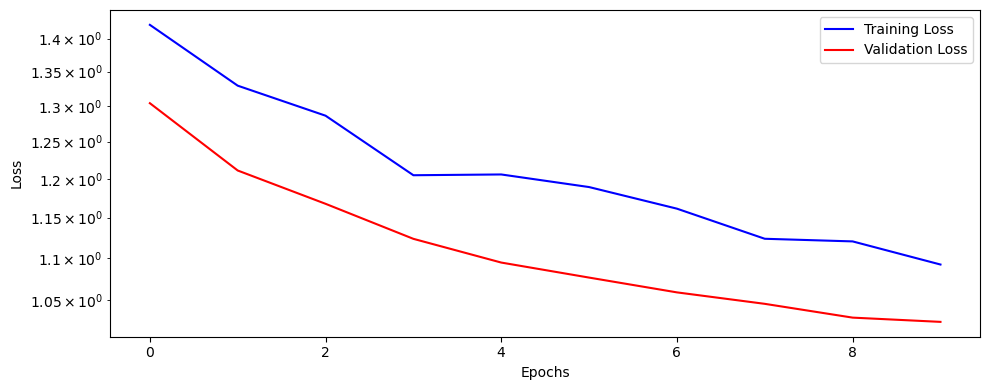

In [82]:
fig = arch_cnn2.plot_losses()

fig.savefig('../images/personal_model/cnn2_losses.png', dpi=300, bbox_inches='tight')

### Accuracy

In [83]:
Architecture.loader_apply(val_loader,
                          arch_cnn2.correct)

tensor([[11, 30],
        [ 6, 30],
        [24, 24],
        [14, 26],
        [21, 34],
        [15, 21]])

In [84]:
Architecture.loader_apply(val_loader,
                          arch_cnn2.correct).sum(axis=0)

tensor([ 91, 165])

In [85]:
(lambda x: x[0].item() / x[1].item())(Architecture.loader_apply(val_loader,
                                                                arch_cnn2.correct).sum(axis=0))

0.5515151515151515

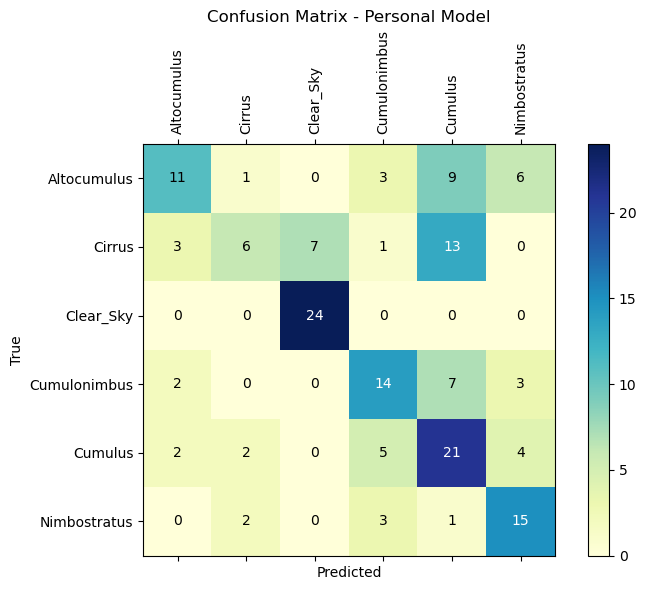

In [86]:
# Creates a Confusion Matrix
def confusion_matrix(loader, arch):
    # Gets the number of classes
    num_classes = len(loader.dataset.classes)
    # Initializes the confusion matrix
    cm = torch.zeros(num_classes, num_classes, dtype=torch.int64)

    # Loops through the mini-batches
    for x_batch, y_batch in loader:
        x_batch = x_batch.to(arch.device)
        y_batch = y_batch.to(arch.device)

        # Gets the predictions
        yhat = arch.predict(x_batch)
        # Converts logits to class indices
        predicted = torch.argmax(torch.tensor(yhat), dim=1)

        # Updates the confusion matrix
        for t, p in zip(y_batch.view(-1), predicted.view(-1)):
            cm[t.long(), p.long()] += 1

    return cm

# Computes the confusion matrix for the validation set
cm = confusion_matrix(val_loader, arch_cnn2)

# Ploting the confusion matrix
def plot_confusion_matrix(cm, classes, title):
    fig, ax = plt.subplots(figsize=(8, 6))
    cax = ax.matshow(cm.numpy(), cmap=plt.cm.YlGnBu)
    fig.colorbar(cax)

    # Set axis labels
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title(title)

    # Set ticks and labels
    ax.set_xticks(np.arange(len(classes)))
    ax.set_yticks(np.arange(len(classes)))
    ax.set_xticklabels(classes, rotation=90, fontsize=10)
    ax.set_yticklabels(classes, fontsize=10)

    # Annotate each cell with the numeric value
    for i in range(len(classes)):
        for j in range(len(classes)):
            ax.text(j, i, cm[i, j].item(), ha='center', va='center', color='white' if cm[i, j] > cm.max() / 2 else 'black')

    plt.tight_layout()
    return fig

# Plot the confusion matrix
fig_cm = plot_confusion_matrix(cm, arch_cnn2.val_loader.dataset.classes,'Confusion Matrix - Personal Model')

# Save the cm image
#fig_cm.savefig('../images/personal_model/C_matrix.png', dpi=300, bbox_inches='tight')

### Regularizing Effect

In [ ]:
torch.manual_seed(13)
# Model Configuration
model_cnn2_nodrop = CNN2(n_feature=15, p=0.0)
multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')
optimizer_cnn2_nodrop = optim.AdamW(model_cnn2_nodrop.parameters(), lr=3e-4)
# Model Training
arch_cnn2_nodrop = Architecture(model_cnn2_nodrop, multi_loss_fn, optimizer_cnn2_nodrop)
arch_cnn2_nodrop.set_loaders(train_loader, val_loader)
arch_cnn2_nodrop.train(50)

Using device: cpu


Training Progress:   2%|▏         | 1/50 [00:48<39:53, 48.85s/it]

Epoch 1/50 - Loss: 1.5844 - Val Loss: 1.3855


Training Progress:   4%|▍         | 2/50 [01:36<38:44, 48.42s/it]

Epoch 2/50 - Loss: 1.2575 - Val Loss: 1.1288


Training Progress:   6%|▌         | 3/50 [02:23<37:18, 47.64s/it]

Epoch 3/50 - Loss: 1.1189 - Val Loss: 1.0751


Training Progress:   8%|▊         | 4/50 [03:10<36:16, 47.31s/it]

Epoch 4/50 - Loss: 1.0715 - Val Loss: 1.0152


Training Progress:  10%|█         | 5/50 [03:57<35:23, 47.19s/it]

Epoch 5/50 - Loss: 1.0120 - Val Loss: 1.0065


Training Progress:  12%|█▏        | 6/50 [04:45<34:42, 47.34s/it]

Epoch 6/50 - Loss: 0.9553 - Val Loss: 0.9948


Training Progress:  14%|█▍        | 7/50 [05:32<33:54, 47.30s/it]

Epoch 7/50 - Loss: 0.9165 - Val Loss: 0.9375


Training Progress:  16%|█▌        | 8/50 [06:20<33:13, 47.46s/it]

Epoch 8/50 - Loss: 0.9121 - Val Loss: 0.9071


Training Progress:  18%|█▊        | 9/50 [07:12<33:23, 48.88s/it]

Epoch 9/50 - Loss: 0.8533 - Val Loss: 0.8892


Training Progress:  20%|██        | 10/50 [08:02<32:51, 49.29s/it]

Epoch 10/50 - Loss: 0.8707 - Val Loss: 0.8736


Training Progress:  22%|██▏       | 11/50 [08:50<31:50, 49.00s/it]

Epoch 11/50 - Loss: 0.8241 - Val Loss: 0.8804


Training Progress:  24%|██▍       | 12/50 [09:39<30:57, 48.87s/it]

Epoch 12/50 - Loss: 0.7914 - Val Loss: 0.8924


Training Progress:  26%|██▌       | 13/50 [10:27<30:04, 48.78s/it]

Epoch 13/50 - Loss: 0.7784 - Val Loss: 0.8369


Training Progress:  28%|██▊       | 14/50 [11:16<29:12, 48.69s/it]

Epoch 14/50 - Loss: 0.7439 - Val Loss: 0.8251


Training Progress:  30%|███       | 15/50 [12:05<28:25, 48.73s/it]

Epoch 15/50 - Loss: 0.7212 - Val Loss: 0.8168


Training Progress:  32%|███▏      | 16/50 [12:53<27:34, 48.65s/it]

Epoch 16/50 - Loss: 0.7150 - Val Loss: 0.8102


Training Progress:  34%|███▍      | 17/50 [13:42<26:46, 48.68s/it]

Epoch 17/50 - Loss: 0.6938 - Val Loss: 0.7924


Training Progress:  36%|███▌      | 18/50 [14:30<25:50, 48.46s/it]

Epoch 18/50 - Loss: 0.6768 - Val Loss: 0.7812


Training Progress:  38%|███▊      | 19/50 [15:18<24:57, 48.30s/it]

Epoch 19/50 - Loss: 0.6712 - Val Loss: 0.7632


Training Progress:  40%|████      | 20/50 [16:05<24:04, 48.14s/it]

Epoch 20/50 - Loss: 0.6481 - Val Loss: 0.8362


Training Progress:  42%|████▏     | 21/50 [16:53<23:14, 48.10s/it]

Epoch 21/50 - Loss: 0.6571 - Val Loss: 0.7496


Training Progress:  44%|████▍     | 22/50 [17:41<22:22, 47.94s/it]

Epoch 22/50 - Loss: 0.6132 - Val Loss: 0.7665


Training Progress:  46%|████▌     | 23/50 [18:30<21:44, 48.31s/it]

Epoch 23/50 - Loss: 0.5933 - Val Loss: 0.7577


Training Progress:  48%|████▊     | 24/50 [19:22<21:22, 49.34s/it]

Epoch 24/50 - Loss: 0.5784 - Val Loss: 0.7425


Training Progress:  50%|█████     | 25/50 [20:17<21:16, 51.06s/it]

Epoch 25/50 - Loss: 0.5968 - Val Loss: 0.7313


Training Progress:  52%|█████▏    | 26/50 [21:14<21:08, 52.84s/it]

Epoch 26/50 - Loss: 0.6425 - Val Loss: 0.7274


Training Progress:  54%|█████▍    | 27/50 [22:11<20:40, 53.94s/it]

Epoch 27/50 - Loss: 0.6022 - Val Loss: 0.7163


Training Progress:  56%|█████▌    | 28/50 [23:03<19:39, 53.63s/it]

Epoch 28/50 - Loss: 0.5437 - Val Loss: 0.7326


Training Progress:  58%|█████▊    | 29/50 [23:56<18:36, 53.19s/it]

Epoch 29/50 - Loss: 0.5076 - Val Loss: 0.7210


Training Progress:  60%|██████    | 30/50 [24:48<17:38, 52.93s/it]

Epoch 30/50 - Loss: 0.4896 - Val Loss: 0.7552


Training Progress:  62%|██████▏   | 31/50 [25:44<17:04, 53.91s/it]

Epoch 31/50 - Loss: 0.5210 - Val Loss: 0.7165


Training Progress:  64%|██████▍   | 32/50 [26:41<16:24, 54.71s/it]

Epoch 32/50 - Loss: 0.5059 - Val Loss: 0.7009


Training Progress:  66%|██████▌   | 33/50 [27:36<15:30, 54.75s/it]

Epoch 33/50 - Loss: 0.4967 - Val Loss: 0.7183


Training Progress:  68%|██████▊   | 34/50 [28:27<14:22, 53.92s/it]

Epoch 34/50 - Loss: 0.4726 - Val Loss: 0.7016


Training Progress:  70%|███████   | 35/50 [29:19<13:16, 53.13s/it]

Epoch 35/50 - Loss: 0.5143 - Val Loss: 0.7178


Training Progress:  72%|███████▏  | 36/50 [30:11<12:21, 52.98s/it]

Epoch 36/50 - Loss: 0.4423 - Val Loss: 0.7266


Training Progress:  74%|███████▍  | 37/50 [31:04<11:26, 52.81s/it]

Epoch 37/50 - Loss: 0.4285 - Val Loss: 0.7236


Training Progress:  76%|███████▌  | 38/50 [31:57<10:35, 52.99s/it]

Epoch 38/50 - Loss: 0.4221 - Val Loss: 0.6959


Training Progress:  78%|███████▊  | 39/50 [32:49<09:40, 52.76s/it]

Epoch 39/50 - Loss: 0.3951 - Val Loss: 0.6980


Training Progress:  80%|████████  | 40/50 [33:43<08:48, 52.85s/it]

Epoch 40/50 - Loss: 0.3697 - Val Loss: 0.7594


Training Progress:  82%|████████▏ | 41/50 [34:37<07:58, 53.22s/it]

Epoch 41/50 - Loss: 0.3649 - Val Loss: 0.6896


Training Progress:  84%|████████▍ | 42/50 [35:28<07:02, 52.81s/it]

Epoch 42/50 - Loss: 0.3473 - Val Loss: 0.6907


Training Progress:  86%|████████▌ | 43/50 [36:21<06:09, 52.75s/it]

Epoch 43/50 - Loss: 0.3501 - Val Loss: 0.6908


Training Progress:  88%|████████▊ | 44/50 [37:13<05:15, 52.62s/it]

Epoch 44/50 - Loss: 0.3422 - Val Loss: 0.7038


Training Progress:  90%|█████████ | 45/50 [38:06<04:22, 52.52s/it]

Epoch 45/50 - Loss: 0.3335 - Val Loss: 0.7309


Training Progress:  92%|█████████▏| 46/50 [38:57<03:28, 52.07s/it]

Epoch 46/50 - Loss: 0.3171 - Val Loss: 0.7348


Training Progress:  94%|█████████▍| 47/50 [39:48<02:35, 51.74s/it]

Epoch 47/50 - Loss: 0.3025 - Val Loss: 0.7283


Training Progress:  96%|█████████▌| 48/50 [40:38<01:42, 51.37s/it]

Epoch 48/50 - Loss: 0.3112 - Val Loss: 0.7264


Training Progress:  98%|█████████▊| 49/50 [41:29<00:51, 51.12s/it]

Epoch 49/50 - Loss: 0.2820 - Val Loss: 0.7218


Training Progress: 100%|██████████| 50/50 [42:18<00:00, 50.77s/it]

Epoch 50/50 - Loss: 0.2737 - Val Loss: 0.7120


In [39]:
def figure11(losses, val_losses, losses_nodrop, val_losses_nodrop):
    fig, axs = plt.subplots(1, 1, figsize=(10, 5))
    axs.plot(losses, 'b', label='Training Losses - Dropout')
    axs.plot(val_losses, 'r', label='Validation Losses - Dropout')
    axs.plot(losses_nodrop, 'b--', label='Training Losses - No Dropout')
    axs.plot(val_losses_nodrop, 'r--', label='Validation Losses - No Dropout')
    plt.yscale('log')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Regularizing Effect')
    fig.legend(loc='upper right', bbox_to_anchor=(0.99, 0.935))
    fig.tight_layout()
    return fig

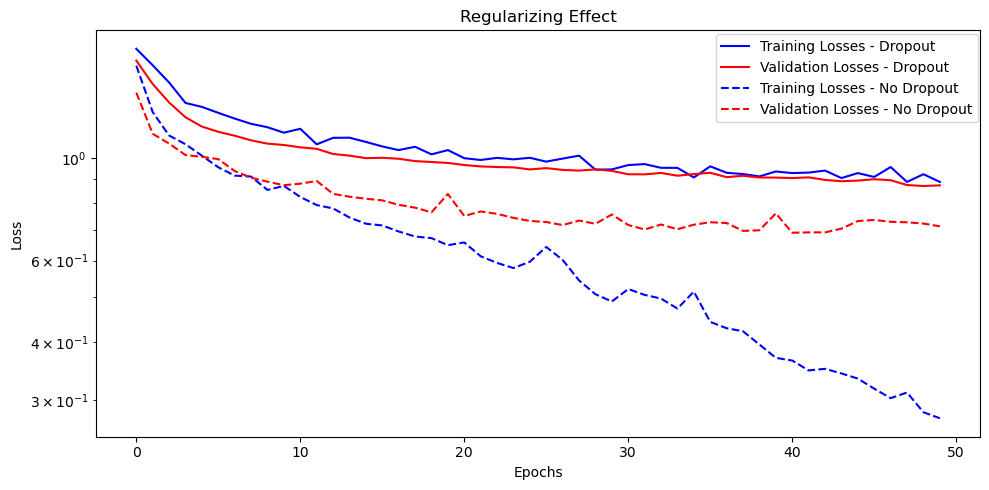

In [40]:
fig = figure11(arch_cnn2.losses, arch_cnn2.val_losses, arch_cnn2_nodrop.losses, arch_cnn2_nodrop.val_losses)

# Save the figure
fig.savefig('../images/personal_model/regularizing_effect.png', dpi=300, bbox_inches='tight')

### Acurracy without the dropout

In [41]:
print('Correctly classified in train:',
    Architecture.loader_apply(train_loader, arch_cnn2_nodrop.correct).sum(axis=0),
    '\n','Correctly classified in val:',
    Architecture.loader_apply(val_loader, arch_cnn2_nodrop.correct).sum(axis=0)
)

Correctly classified in train: tensor([609, 657]) 
 Correctly classified in val: tensor([123, 165])


In [42]:
print("Accuracy in train:",
    (lambda x: x[0].item() / x[1].item())(Architecture.loader_apply(train_loader, arch_cnn2_nodrop.correct).sum(axis=0)),
    '\n','Accuracy in val:',
    (lambda x: x[0].item() / x[1].item())(Architecture.loader_apply(val_loader, arch_cnn2_nodrop.correct).sum(axis=0))
)

Accuracy in train: 0.9269406392694064 
 Accuracy in val: 0.7454545454545455


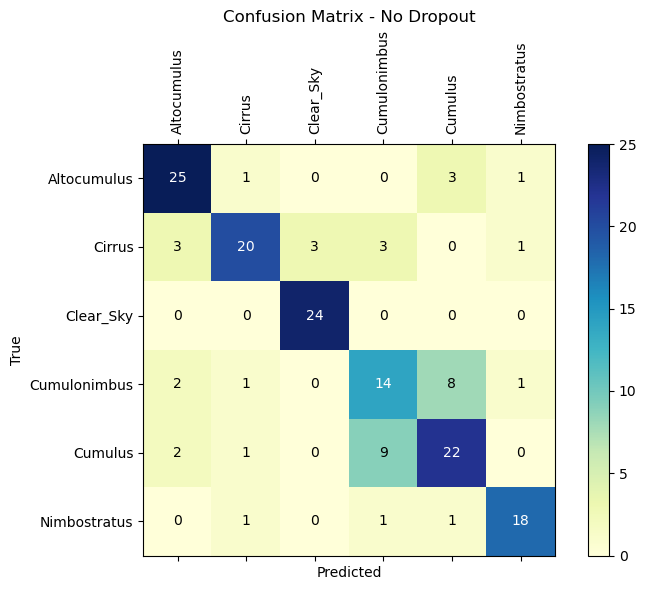

In [43]:
cm = confusion_matrix(val_loader, arch_cnn2_nodrop)

# Ploting the confusion matrix
def plot_confusion_matrix2(cm, classes, title):
    fig, ax = plt.subplots(figsize=(8, 6))
    cax = ax.matshow(cm.numpy(), cmap=plt.cm.YlGnBu)
    fig.colorbar(cax)

    # Set axis labels
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title(title)

    # Set ticks and labels
    ax.set_xticks(np.arange(len(classes)))
    ax.set_yticks(np.arange(len(classes)))
    ax.set_xticklabels(classes, rotation=90, fontsize=10)
    ax.set_yticklabels(classes, fontsize=10)

    # Annotate each cell with the numeric value
    for i in range(len(classes)):
        for j in range(len(classes)):
            ax.text(j, i, cm[i, j].item(), ha='center', va='center', color='white' if cm[i, j] > cm.max() / 2 else 'black')

    plt.tight_layout()
    return fig

fig_cm = plot_confusion_matrix2(cm, arch_cnn2_nodrop.val_loader.dataset.classes,"Confusion Matrix - No Dropout")

# Save the cm image

fig_cm.savefig('../images/personal_model/C_matrix_nodrop.png', dpi=300, bbox_inches='tight')

In [44]:
Architecture.loader_apply(val_loader,
                          arch_cnn2_nodrop.correct)

tensor([[25, 30],
        [20, 30],
        [24, 24],
        [14, 26],
        [22, 34],
        [18, 21]])

### Acurracy with Dropout

In [ ]:
print('Correctly classified in train:',
    Architecture.loader_apply(train_loader, arch_cnn2.correct).sum(axis=0),
    '\n','Correctly classified in val:',
    Architecture.loader_apply(val_loader, arch_cnn2.correct)
)

In [ ]:
print('Accuracy in train:',
    (lambda x: x[0].item() / x[1].item())(Architecture.loader_apply(train_loader, arch_cnn2.correct).sum(axis=0)),
    '\n','Accuracy in val:',
    (lambda x: x[0].item() / x[1].item())(Architecture.loader_apply(val_loader, arch_cnn2.correct).sum(axis=0))
)

### Visualizing Filters

The conv1 filter visualization shows 3-channel (RGB) 3×3 kernels that learn low-level features such as edges and color gradients. These weights exhibit clear directional patterns and contrasts typical of early-layer feature detectors.

In contrast, the conv2 visualization displays 5-channel 3×3 kernels, with each channel corresponding to a feature map output from conv1. These filters capture more abstract, higher-order combinations of the first-layer features. The weights appear less interpretable in isolation, reflecting their role in integrating and recombining simpler patterns into more complex representations useful for classification.

This progression illustrates the hierarchical nature of CNNs: conv1 learns localized, low-level features, while conv2 composes them into richer, more discriminative abstractions.

In [45]:
model_cnn2.conv1.weight.shape

torch.Size([5, 3, 3, 3])

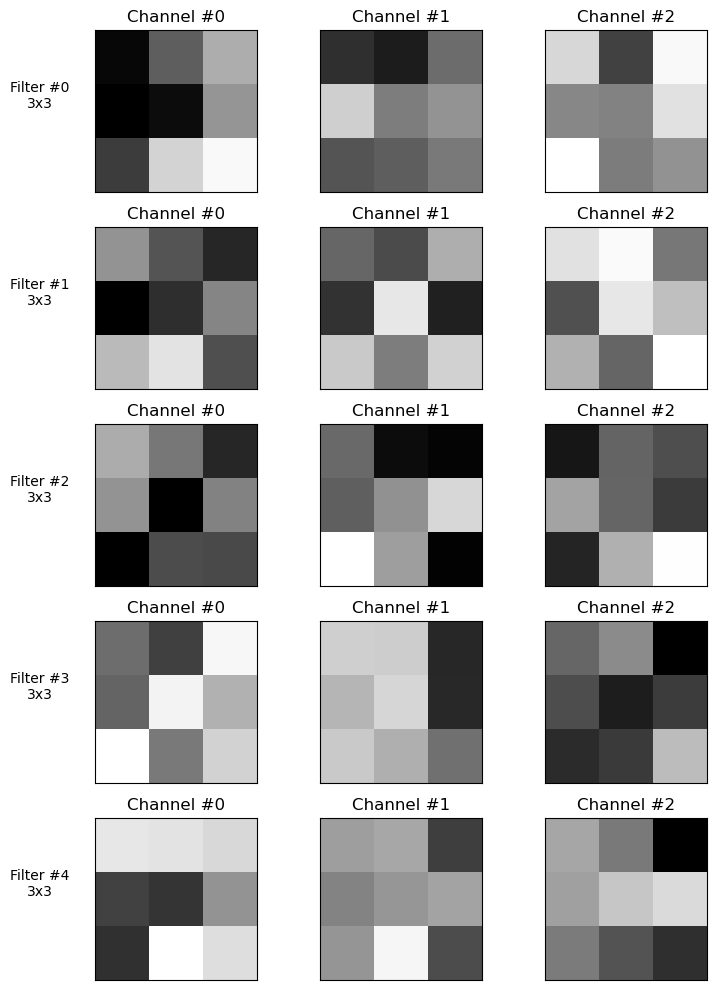

In [46]:
fig = arch_cnn2.visualize_filters('conv1')

fig.savefig('../images/personal_model/filters_conv1.png', dpi=300, bbox_inches='tight')

In [47]:
model_cnn2.conv2.weight.shape

torch.Size([5, 5, 3, 3])

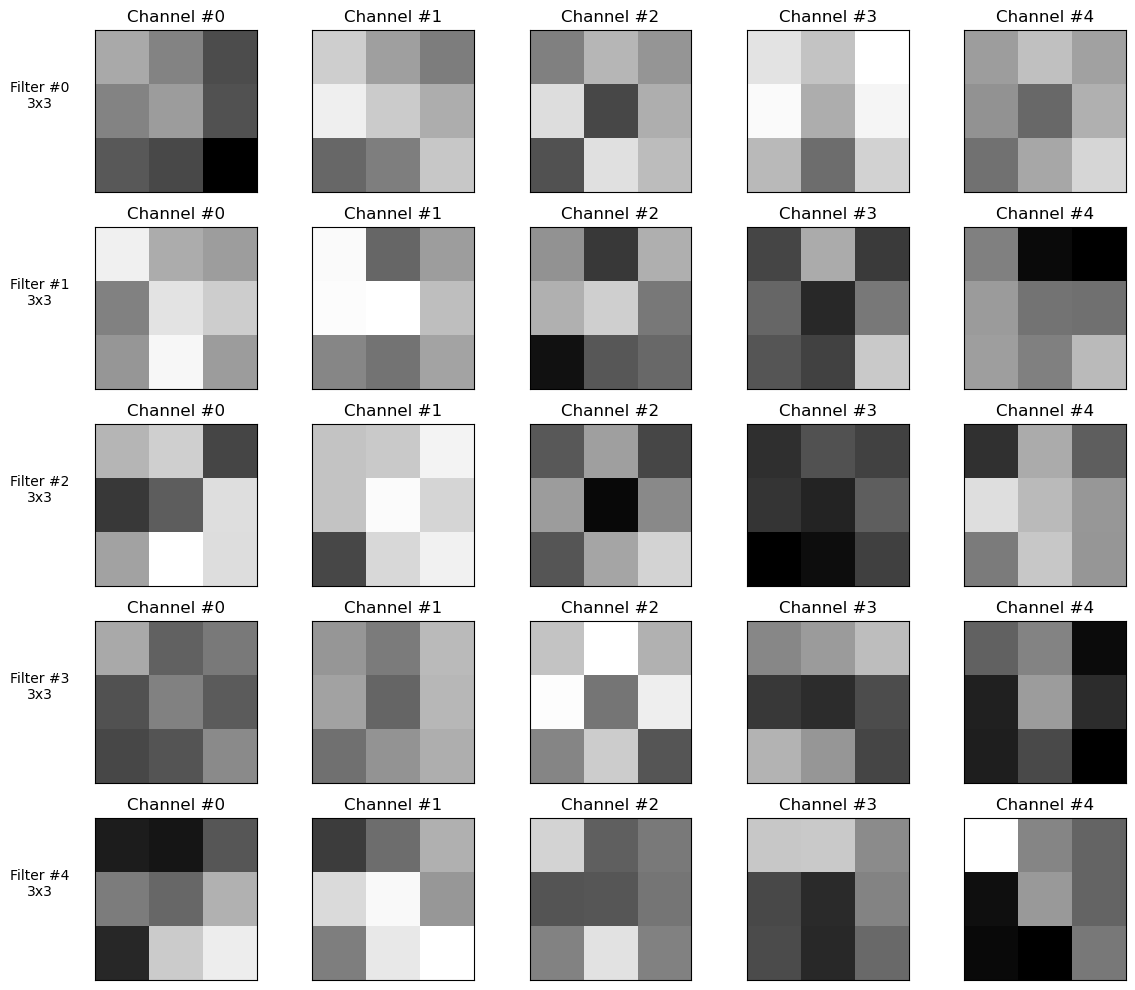

In [48]:
fig = arch_cnn2.visualize_filters('conv2')

fig.savefig('../images/personal_model/filters_conv2.png', dpi=300, bbox_inches='tight')

In [ ]:
# Saving the model checkpoint

arch_cnn2.save_checkpoint("../models/personal_model_v2.pth")